In [1]:
!pip3 install gymnasium[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:00


In [2]:
!pip install autorom[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=bc939b61531da6c961fd4471c4699c85c30a384210b94fecca7f7a0c0eb7794c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [3]:
import gymnasium as gym
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import random
from itertools import count
import cv2
from itertools import count
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle

In [4]:
class DQN(nn.Module):

    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        self.obs_shape = obs_shape
        self.num_actions = n_actions
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=(8,8), stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(4,4), stride=2),
            nn.ReLU(),
        )

        # with torch.no_grad():
        #   dummy = torch.zeros((1,*obs_shape))
        #   x = self.conv_layers(dummy)
        #   s = x.shape
        #   fc_size = s[1] * s[2] * s[3]

        self.fc_layers = nn.Sequential(
            nn.Linear(32*9*9, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = x/255
        x = self.conv_layers(x) 
        x = x.view(x.shape[0],-1)
        x = self.fc_layers(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
class FrameStackingAndResizingEnv:
  def __init__(self, env, w, h, num_stack=4):
    self.env = env 
    self.n = num_stack 
    self.w = self.h = h 
    self.buffer = np.zeros((num_stack, h, w), 'uint8') 
    self.frame = None

  def _preprocess_frame(self, frame): 
    # print('width_height: ',width_height)
    # print(frame[0])
    # print('image before resize: ',frame)
    # print('frame1: ',frame[1])
    image = cv2.resize(frame[0], (self.w, self.h)) 
    # print('image after resize:',image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    #
    return image

  def _step_preprocess_frame(self, frame): 
    # print('width_height: ',width_height)
    # print(frame[0])
    # print('image before resize: ',frame)
    # print('frame1: ',frame[1])
    image = cv2.resize(frame, (self.w, self.h)) 
    # print('image with no resize:',image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    #
    return image

  @property 
  def observation_space(self): 
    # gym.spaces.Box() 
    return np.zeros((self.n, self.h, self.w)) 
    
  @property 
  def action_space(self): 
    return self.env.action_space
    
  def step(self, action):
    im, reward, _, done, info = self.env.step(action) 
    self.frame = im.copy()
    # print('step before img preprocess:',im.shape)
    im = self._step_preprocess_frame(im) 
    # print('step after img preprocess:',im.shape)
    self.buffer[1:self.n, :, :] = self.buffer[0:self.n-1, :, :] 
    self.buffer[0, :, :] = im 
    return self.buffer.copy(), reward, done, info 
    
  def render(self, mode=None):
    if mode == 'rgb_array':
      return self.frame
    return super(FrameStackingAndResizingEnv,self).render()

  def reset(self):
    im = self.env.reset() 
    # print('reset before img preprocess: ',im)
    im = self._preprocess_frame(im) 
    # print('reset after img preprocess: ',im.shape)
    self.buffer = np.stack([im]*self.n,0) 
    return self.buffer.copy()
    
  def render(self, mode): 
    self.env.render(mode)
  

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        

    def push(self, state, action, next_state, reward, terminated):
        experience = [state, action, next_state, reward, terminated]
        self.buffer.append(experience)
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)
        

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [7]:
class DQNAgent():
    def __init__(self, n_observations, n_actions, max_epsilon, epsilon_decay, min_epsilon, batch_size, decay_factor, tau, alpha):

        # self.device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_actions = n_actions
        self.n_observations = n_observations

        self.buffer = ReplayMemory(15000)

        self.policy_network = DQN(env.observation_space.shape, env.action_space.n).to(device)
        self.target_network = DQN(env.observation_space.shape, env.action_space.n).to(device)

        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=alpha, amsgrad=True)
        self.loss_fn = nn.MSELoss()

        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.decay_factor = decay_factor
        self.tau = tau
        self.alpha = alpha
        self.count_steps = 0
        self.epsilons = []
        self.rewards = []


    def epsilon_greedy_action(self, env, state, epsilon, shoot):
        non_shoot_actions = [0, 2, 3]
        random_int = np.random.uniform(0, 1)        
        self.count_steps += 1
        if shoot:
          return torch.tensor([[1]], device=device, dtype=torch.long)
        else:
          if random_int > epsilon:
              with torch.no_grad():
                  return self.policy_network(state).max(1)[1].view(1, 1)
          else:
              return torch.tensor([[random.choice(non_shoot_actions)]], device=self.device, dtype=torch.long)

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return
        transitions = self.buffer.sample(self.batch_size)

        states, actions, next_state, rewards, terminated = zip(*transitions)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        terminateds = torch.cat(terminated)

        # CREATE TENSOR OF ALL EXPERIENCES WHICH DID NOT TERMINATE.
        non_final_experiences = []
        for d in terminated:
            non_final_experiences.append(d != True)
        non_final_tensor = torch.tensor(non_final_experiences, dtype=torch.bool)

        # GET THE NEXT STATES OF ALL THE EXPERIENCES IN NON_FINAL_EXPERIENCES.
        non_final_tensor_next_states = []
        for i in range(len(next_state)):
            if terminated[i] == 0:
                non_final_tensor_next_states.append(next_state[i])
        non_final_tensor_next_states = torch.cat(non_final_tensor_next_states)

        # GET Q VALUES
        state_action_q_values = self.policy_network(states)[torch.arange(states.shape[0]), actions.squeeze(1)]
        state_action_q_values = state_action_q_values.unsqueeze(1)

        # INITIALISE ARRAY TO STORE Q VALUES
        next_state_values = torch.zeros(self.batch_size, device=self.device)

        # GET Q VALUES FOR NEXT STATE, BEST ACTION(AS PER PRIMARY NETWORK)
        with torch.no_grad():
            next_state_values[non_final_tensor] = self.target_network(non_final_tensor_next_states).max(1)[0]
        
        # GET EXPECTED Q VALUES
        expected_state_action_q_values = (next_state_values * self.decay_factor) + rewards

        # CALCULATE LOSS 
        loss = self.loss_fn(state_action_q_values, expected_state_action_q_values.unsqueeze(1))

        #clear gradients from previous batch
        self.optimizer.zero_grad()

        # perform gradient descent on the loss
        loss.backward()

        # update model parameters
        self.optimizer.step()

    def train(self, env, num_episodes):
        converge_count = 0
        frames = []
        for eps in tqdm(range(num_episodes)):
            state = env.reset()
            remaining_lives = 5
            max_frames = 10000
            shoot = True
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            epsilon = max(self.min_epsilon, (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay * eps))
            self.epsilons.append(epsilon)
            total_reward = 0
            C_count = 0

            done = False
            while done == False:
                # PERFROM ACTION USING EPSILON GREEDY POLICY
                action = self.epsilon_greedy_action(env, state, epsilon, shoot)
                shoot = False
                # TAKE STEP USING ACTION DERIVED ABOVE
                observation, reward, terminated, info = env.step(action.item())
                # print('observation: ',observation)
                # print('reward: ',reward)
                # print('terminated: ',terminated)
                
                # print('info: ',info)
                # plt.imshow(observation[0])
                frames.append(env.frame)
                # if env.unwrapped.spec.id == 'MountainCar-v0':
                #     reward = 100*((math.sin(3*observation[0]) * 0.025 + 0.7 * observation[1] * observation[1]) - (math.sin(3*state[0,0]) * 0.025 + 0.7 * state[0,1] * state[0,1]))

                reward = torch.tensor([reward], device=self.device)

                if remaining_lives!= info.get('lives'):
                  remaining_lives -= 1
                  shoot = True
                  if remaining_lives == 0:
                    terminated=True
                    print('GAME OVER!!')

                if info.get('episode_frame_number')>max_frames:
                  print('MAX FRAMES PER EPISODE REACHED!!')
                  terminated=True

                terminated = torch.tensor([terminated], device=self.device)
                done = terminated
                total_reward += reward

                if terminated and remaining_lives>0 and info.get('episode_frame_number')<max_frames:
                  print('LEVEL COMPLETE!!!!!!!!!')

                next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store transition in buffer
                self.buffer.push(state, action, next_state, reward, terminated)

                state = next_state
                self.train_step()

                C_count += 1

                # SYNC NETWORKS USING SOFT UPDATES FOR EVERY C STEPS
                if C_count == 10:

                  C_count = 0
                  # GET TARGET NETWORK WEIGHTS
                  target_network_state_dict = self.target_network.state_dict()
                  # GET PRIMARY NETWORK WEIGHTS
                  policy_network_state_dict = self.policy_network.state_dict()
                  for key in policy_network_state_dict:
                      target_network_state_dict[key] = policy_network_state_dict[key]*self.tau + target_network_state_dict[key]*(1-self.tau)
                  # UPDATE TARGET NETWORK
                  self.target_network.load_state_dict(target_network_state_dict)

                if done:
                    break

            self.rewards.append(total_reward)
            print('Episode: ',eps,' Reward: ',total_reward)
            

        # SAVE NETWORK WEIGHTS
        with open('DQN_Breakout.pkl', 'wb') as f:
          pickle.dump(self.policy_network, f)
        print('Training Finished')

    def plot_rewards(self):
        plt.xlabel('Episode')
        plt.ylabel('Rewards')
        plt.plot(self.rewards)

    def evaluate(self, env, num_episodes):
      episode_rewards = []
      for episode in range(num_episodes):
          state = env.reset()
          episode_reward = 0
          done = False
          while not done:
              with torch.no_grad():
                  state_tensor = torch.FloatTensor(state).unsqueeze(0)
                  q_values = self.target_network(state_tensor)
                  action = q_values.max(1)[1].item()
              next_state, reward, done, _ = env.step(action)
              episode_reward += reward
              state = next_state
          episode_rewards.append(episode_reward)
          print("Episode: {}, Reward: {}".format(episode, episode_reward))
      avg_reward = sum(episode_rewards) / num_episodes
      print("Average reward over {} episodes: {}".format(num_episodes, avg_reward))
      plt.plot(episode_rewards)
      plt.ylabel('Rewards')
      plt.xlabel('Number of episodes')

    def plot_decay(self):
        plt.plot(self.epsilons)
        plt.ylabel('Epsilon Value')
        plt.xlabel('Episodes')
        

In [8]:
env = gym.make("BreakoutNoFrameskip-v4")
# env = gym.make("BreakoutDeterministic-v4")

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)


env = FrameStackingAndResizingEnv(env, 84, 84, 4)

obs = env.reset()
print(obs.shape)


# if gpu is to be used
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(4, 84, 84)


obs: (4, 84, 84)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


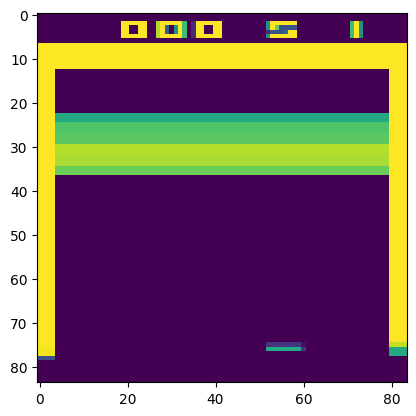

In [9]:
obs = env.reset()
print('obs:',obs.shape)
import matplotlib.pyplot as plt
plt.imshow(obs[0])

(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8), 0.0, False, {'lives': 5, 'episode_frame_number': 1, 'frame_number': 1})


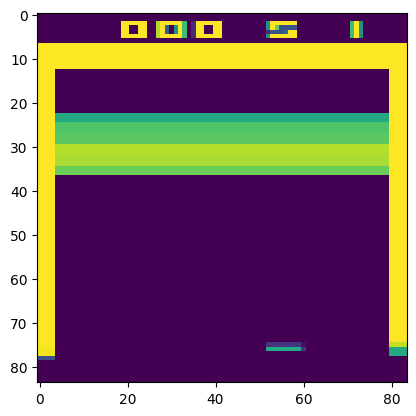

In [10]:
print(env.step(1))
plt.imshow(obs[0])
# print(f"Info: {info}")

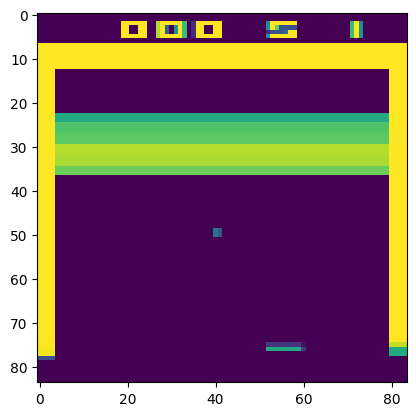

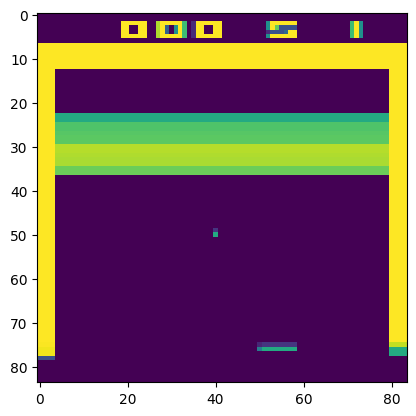

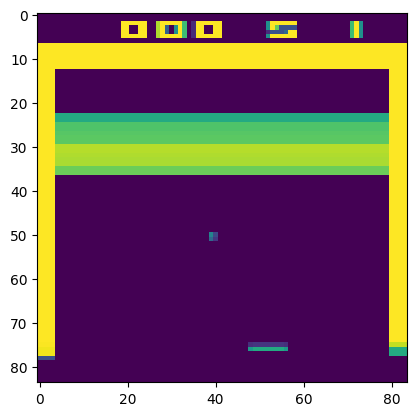

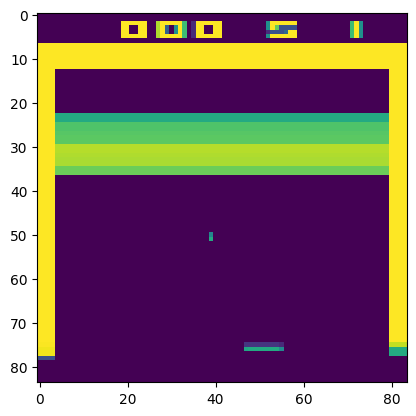

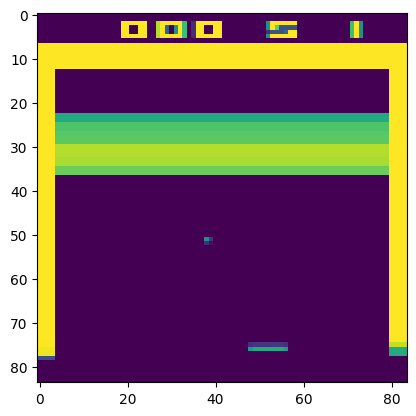

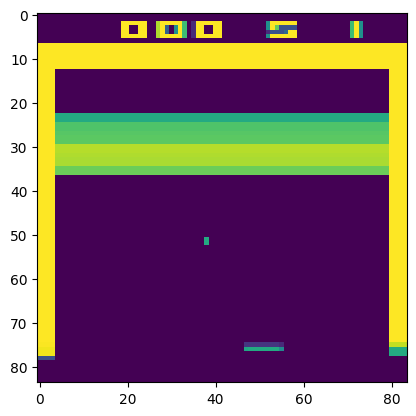

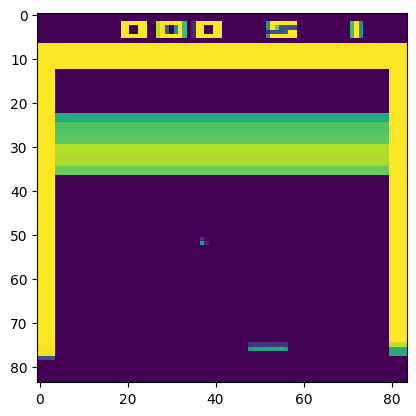

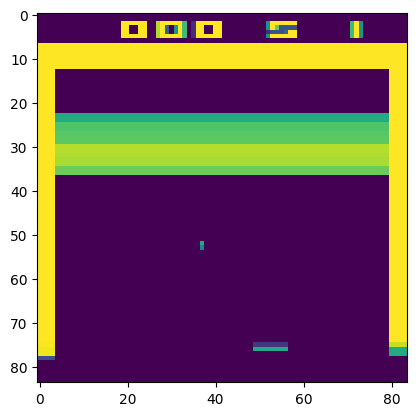

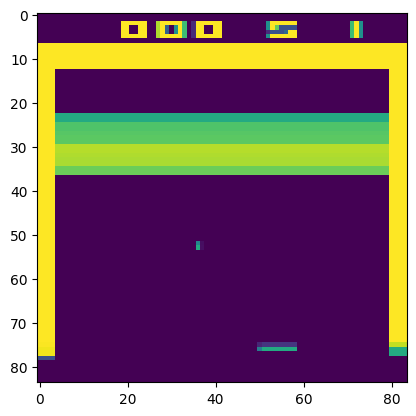

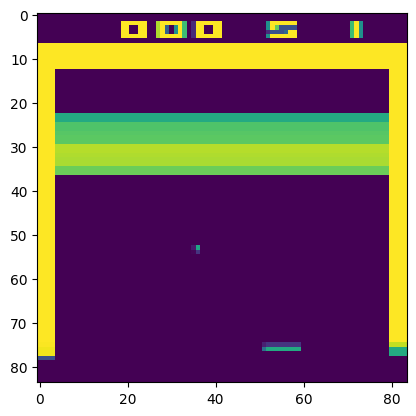

In [11]:
obs = env.reset()
obs = env.step(1)

from IPython import display
import time

for i in range(10):
    action = env.action_space.sample()
    new_obs,_,_,info = env.step(action)
    # print(new_obs.shape)
    plt.imshow(new_obs[0])
    # plt.pause(0.001) 
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    
    plt.show()
    #print(f"Info: {info}")
    obs = new_obs
    #time.sleep(3)



In [12]:
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.05
batch_size = 128
decay_factor = 0.99
tau = 0.005
alpha = 0.001
no_of_episodes = 100

agent = DQNAgent(n_observations, n_actions, max_epsilon, epsilon_decay, min_epsilon, batch_size, decay_factor, tau, alpha)
agent.train(env, no_of_episodes)


  0%|          | 0/100 [00:00<?, ?it/s]

GAME OVER!!
Episode:  0  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  1  Reward:  tensor([0.], device='cuda:0')
GAME OVER!!
Episode:  2  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  3  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  4  Reward:  tensor([4.], device='cuda:0')
GAME OVER!!
Episode:  5  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  6  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  7  Reward:  tensor([1.], device='cuda:0')
GAME OVER!!
Episode:  8  Reward:  tensor([0.], device='cuda:0')
GAME OVER!!
Episode:  9  Reward:  tensor([0.], device='cuda:0')
GAME OVER!!
Episode:  10  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  11  Reward:  tensor([0.], device='cuda:0')
GAME OVER!!
Episode:  12  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  13  Reward:  tensor([1.], device='cuda:0')
GAME OVER!!
Episode:  14  Reward:  tensor([2.], device='cuda:0')
GAME OVER!!
Episode:  15  Reward:  

In [13]:
rew = [r.cpu().numpy() for r in agent.rewards]

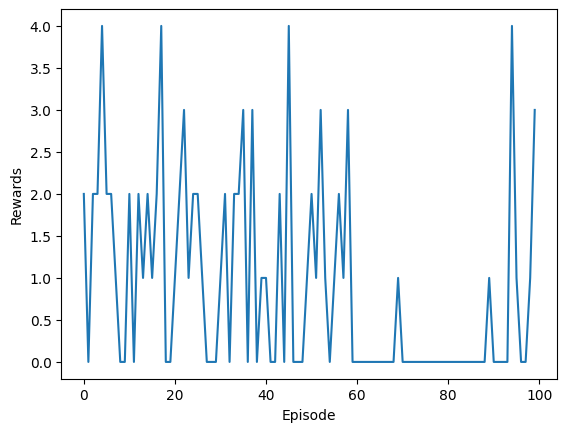

In [14]:
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(rew)

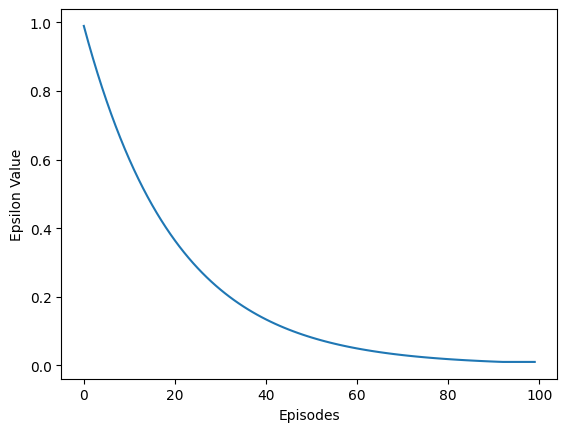

In [15]:
agent.plot_decay()